In [3]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import warnings

#=================================================
# Modify paths to point to output files
#=================================================
# Case name (Straight coast)
case_straight = 'Straight Coast'

# path to ocean_annual file
path_year_straight = '/data/sragen/aquaplanet/MASTERS/straight_coast/run/DATA/goodcore_300yr/21000101.ocean_annual.nc'
dy_straight = xr.open_dataset(path_year_straight, decode_times=True)

# path to ocean_month file
path_month_straight = '/data/sragen/aquaplanet/MASTERS/straight_coast/run/DATA/goodcore_300yr/21000101.ocean_month.nc'
dm_straight = xr.open_dataset(path_month_straight, decode_times=True)

# path to save figures
fig_path_straight = '/data/sragen/aquaplanet/MASTERS/straight_coast/run/DATA/goodcore_300yr/FIGURES/'


# Case name (Both Coast)
case_both = 'Both Coast'

# path to ocean_annual file
path_year_both = '/data/sragen/aquaplanet/MASTERS/both_coast/run/DATA/goodcore_300yr/21000101.ocean_annual.nc'
dy_both = xr.open_dataset(path_year_both, decode_times=True)

# path to ocean_month file
path_month_both = '/data/sragen/aquaplanet/MASTERS/both_coast/run/DATA/goodcore_300yr/21000101.ocean_month.nc'
dm_both = xr.open_dataset(path_month_both, decode_times=True)

# path to save figures
fig_path_both = '/data/sragen/aquaplanet/MASTERS/both_coast/run/DATA/goodcore_300yr/FIGURES/'

#=================================================
# Ignore runtime warnings: mean of empty slice
#=================================================
warnings.filterwarnings("ignore", message="Mean of empty slice")

#=================================================
# Modify latitudes to point to western and eastern
# boundaries of small basin and northern extent of SO.
# Comment out for AQUA and RIDGE cases. 
#=================================================
x_west = np.where(dy_straight['xh']==211)[0][0]
x_east = np.where(dy_straight['xh']==351)[0][0]
y = np.where(dy_straight['yq']==-35)[0][0]
y_south = np.where(dy_straight['yq']==-71)[0][0]
y_north = np.where(dy_straight['yq']==71)[0][0]

In [14]:
# functions
def calculate_OHT(T_ady_2d, T_diffy_2d):
    tady = np.where(np.abs(T_ady_2d) == 1e+20, np.nan, T_ady_2d)
    tady_avg = np.nanmean(tady, axis=0)
    tady_zonal = np.nansum(tady_avg, axis=1)
    tdiffy = np.where(np.abs(T_diffy_2d) == 1e+20, np.nan, T_diffy_2d)
    tdiffy_avg = np.nanmean(tdiffy, axis=0)
    tdiffy_zonal = np.nansum(tdiffy_avg, axis=1)
    OHT = (tady_zonal + tdiffy_zonal)/1e15
    return OHT

def calculate_global_sfn(vmo, vhGM):
    vmo_slice = (np.nanmean(vmo[-31:-1,:,:,:], axis=0))
    vhGM_slice = (np.nanmean(vhGM[-31:-1,:,:,:], axis=0))
    sfn_global_mean = (np.cumsum(np.nansum(vmo_slice/1025, axis=2), axis=0))/(1e6)
    sfn_global_res = (np.cumsum(np.nansum(vhGM_slice/1025, axis=2), axis=0))/(1e6)
    sfn_global_resmean = sfn_global_mean + sfn_global_res
    return sfn_global_mean, sfn_global_res, sfn_global_resmean

def calculate_basin_sfn(vmo, vhGM, x_west, x_east, y_south, y_north):
    vmo_slice = (np.nanmean(vmo[-31:-1,:,:,:], axis=0))
    vhGM_slice = (np.nanmean(vhGM[-31:-1,:,:,:], axis=0))
    sfn_basin_mean = (np.cumsum(np.nansum((vmo_slice[:,y_south:y_north,x_west:x_east])/1025, axis=2), axis=0))/(1e6)
    sfn_basin_res = (np.cumsum(np.nansum((vhGM_slice[:,y_south:y_north,x_west:x_east])/1025, axis=2), axis=0))/(1e6)
    sfn_basin_resmean = sfn_basin_mean + sfn_basin_res
    return sfn_basin_mean, sfn_basin_res, sfn_basin_resmean

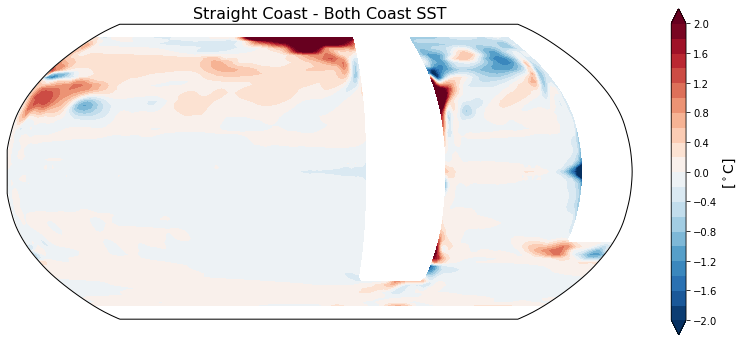

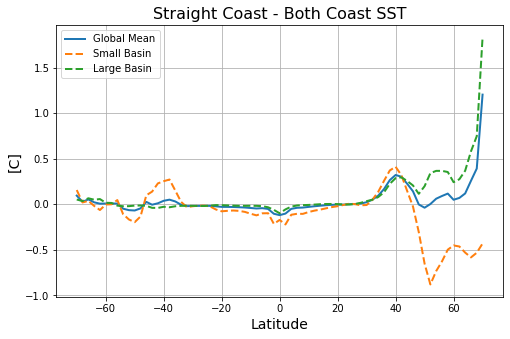

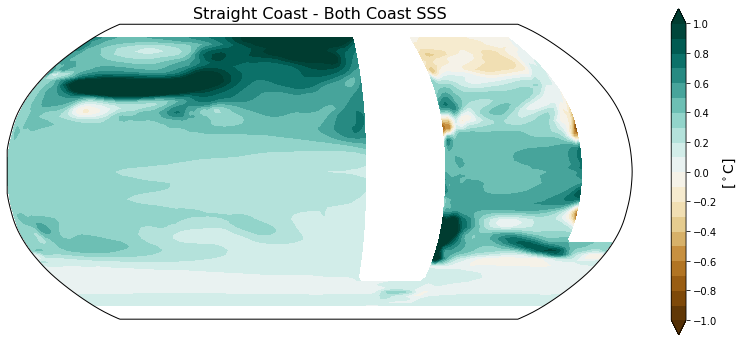

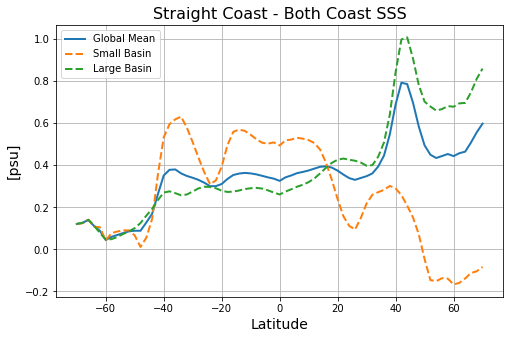

In [12]:
sst_avg = dy_straight['tos'].mean(dim='time') - dy_both['tos'].mean(dim='time')
sss_avg = dy_straight['sos'].mean(dim='time') - dy_both['sos'].mean(dim='time')

b = np.linspace(-2, 2, 21, endpoint=True)
t = np.linspace(-2, 2, 11, endpoint=True)
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=180.0))
plt.contourf(dy_straight['xh'], dy_straight['yh'], sst_avg, b, 
             cmap='RdBu_r', extend='both',transform=ccrs.PlateCarree())
cbar = plt.colorbar(ticks=t, boundaries=t, spacing='uniform', extend='both')
cbar.ax.set_ylabel('[$^\circ$C]', fontsize=14)
plt.ylabel('Latitude', fontsize=14), plt.xlabel('Longitude', fontsize=14)
plt.title('{} - {} SST'.format(case_straight, case_both), fontsize=16)
# plt.savefig(fig_path+'SST.png')
plt.show()

plt.subplots(figsize=(8,5))
plt.plot(dy_straight['yh'], np.nanmean(sst_avg, axis=1), linewidth=2, label='Global Mean')
# Following two lines are for configurations with more than one basin
plt.plot(dy_straight['yh'], np.nanmean(sst_avg[:,x_west:x_east], axis=1), '--',linewidth=2, label='Small Basin')
plt.plot(dy_straight['yh'], np.nanmean(sst_avg[:,:x_west], axis=1), '--', linewidth=2, label='Large Basin')
#
plt.ylabel('[C]', fontsize=14), plt.xlabel('Latitude', fontsize=14)
plt.title('{} - {} SST'.format(case_straight, case_both), fontsize=16)
plt.grid()
plt.legend()
# plt.savefig(fig_path+'SST_section.png')
plt.show()

b_salt = np.linspace(-1, 1, 21, endpoint=True)
t_salt = np.linspace(-1, 1, 11, endpoint=True)
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=180.0))
plt.contourf(dy_straight['xh'], dy_straight['yh'], sss_avg, b_salt, 
             cmap='BrBG', extend='both', transform=ccrs.PlateCarree())
cbar = plt.colorbar(ticks=t_salt, boundaries=t_salt, spacing='uniform', extend='both')
cbar.ax.set_ylabel('[$^\circ$C]', fontsize=14)
plt.ylabel('Latitude', fontsize=14), plt.xlabel('Longitude', fontsize=14)
plt.title('{} - {} SSS'.format(case_straight, case_both), fontsize=16)
# plt.savefig(fig_path+'SSS.png')
plt.show()

plt.subplots(figsize=(8,5))
plt.plot(dy_straight['yh'], np.nanmean(sss_avg, axis=1), linewidth=2, label='Global Mean')
# Following two lines are for configurations with more than one basin
plt.plot(dy_straight['yh'], np.nanmean(sss_avg[:,x_west:x_east], axis=1), '--', linewidth=2, label='Small Basin')
plt.plot(dy_straight['yh'], np.nanmean(sss_avg[:,:x_west], axis=1), '--', linewidth=2, label='Large Basin')
#
plt.ylabel('[psu]', fontsize=14), plt.xlabel('Latitude', fontsize=14)
plt.title('{} - {} SSS'.format(case_straight, case_both), fontsize=16)
plt.grid()
plt.legend()
# plt.savefig(fig_path+'SSS_section.png')
plt.show()

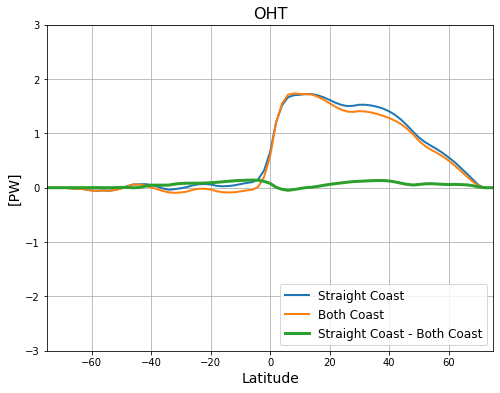

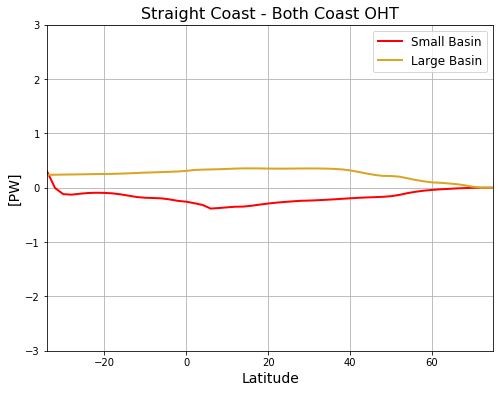

In [21]:
OHT_straight = calculate_OHT(dm_straight['T_ady_2d'], dm_straight['T_diffy_2d'])
OHT_both = calculate_OHT(dm_both['T_ady_2d'], dm_both['T_diffy_2d'])
OHT = OHT_straight - OHT_both

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(dm_straight['yq']+1, OHT_straight, linewidth=2, label=case_straight)
ax.plot(dm_both['yq']+1, OHT_both, linewidth=2, label=case_both)
ax.plot(dm_straight['yq']+1, OHT, linewidth=3, label='{} - {}'.format(case_straight, case_both))
plt.title('OHT', fontsize=16)
plt.grid()
plt.xlim(-75,75)
plt.ylim(-3, 3)
plt.legend(fontsize=12, loc='lower right')
plt.xlabel('Latitude', fontsize=14), plt.ylabel('[PW]', fontsize=14)
# plt.savefig(fig_path+'OHT_global.png')
plt.show()

OHT_small_straight = calculate_OHT(dm_straight['T_ady_2d'][:,:,x_west:x_east], 
                                   dm_straight['T_diffy_2d'][:,:,x_west:x_east])
OHT_large_straight = calculate_OHT(dm_straight['T_ady_2d'][:,:,:x_west], dm_straight['T_diffy_2d'][:,:,:x_west])
OHT_small_both = calculate_OHT(dm_both['T_ady_2d'][:,:,x_west:x_east], 
                                   dm_both['T_diffy_2d'][:,:,x_west:x_east])
OHT_large_both = calculate_OHT(dm_both['T_ady_2d'][:,:,:x_west], dm_both['T_diffy_2d'][:,:,:x_west])

OHT_small = OHT_small_straight - OHT_small_both
OHT_large = OHT_large_straight - OHT_large_both

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(dm_straight['yq']+1, OHT_small, color='red', linewidth=2, label='Small Basin')
ax.plot(dm_straight['yq']+1, OHT_large, color='goldenrod', linewidth=2, label='Large Basin')
plt.title('{} - {} OHT'.format(case_straight, case_both), fontsize=16)
plt.grid()
plt.xlim(-34,75)
plt.ylim(-3, 3)
plt.legend(fontsize=12)
plt.xlabel('Latitude', fontsize=14), plt.ylabel('[PW]', fontsize=14)
# plt.savefig(fig_path+'OHT_basins.png')
plt.show()